In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
path= untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/ubuntu/.fastai/data/camvid/images'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/vidFrames'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/export.pkl'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/train.txt'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/codes.txt'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/labels'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/valid.txt'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/newImages')]

In [4]:
# this is the speed-challenge images

pathVision = path/'vidFrames'

In [6]:
fnamesVis = get_image_files(pathVision)
fnamesVis[:3]

[PosixPath('/home/ubuntu/.fastai/data/camvid/vidFrames/frame17512.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/vidFrames/frame9361.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/vidFrames/frame19028.jpg')]

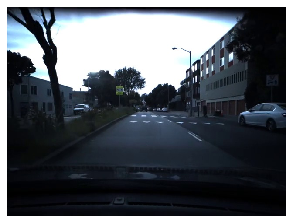

In [7]:
newImage = fnamesVis[0]
img = open_image(newImage)
img.show(figsize=(5,5))

In [8]:
type(fnamesVis)

list

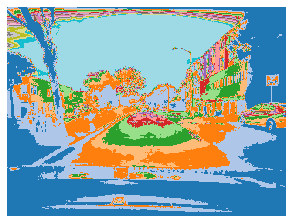

In [9]:
mask = open_mask(newImage)
mask.show(figsize=(5,5),alpha=1)

In [10]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([480, 640]), tensor([[[ 5,  4,  4,  ...,  0,  0,  0],
          [ 7,  6,  6,  ...,  0,  0,  0],
          [11,  9,  8,  ...,  0,  0,  0],
          ...,
          [ 4,  4,  3,  ...,  5,  5,  5],
          [ 4,  4,  3,  ...,  4,  4,  4],
          [ 4,  4,  3,  ...,  4,  4,  3]]]))

In [13]:
path_lbl = path/'labels'
path_img = path/'images'

In [12]:
# Not sure if I even need this ... ?
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

In [14]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [15]:
# Speeds from speed-challenge
speeds = np.loadtxt(path/'train.txt'); speeds

array([28.105569, 28.105569, 28.106527, 28.130404, ...,  2.289795,  2.292917,  2.2606  ,  2.206759])

In [17]:
len(speeds)

20400

## Dataset

In [19]:
size = src_size//2
free = gpu_mem_get_free_no_cache()
if free > 8200:
    bs = 8
else:
    bs=4
print(f"using bs{bs}, have {free}MB of GPU RAM free")

using bs8, have 10652MB of GPU RAM free


In [33]:
src = (SegmentationItemList.from_folder(pathVision)
       .split_none()
      .label_empty())


# src = (SegmentationItemList.from_folder(path_img)
#       .split_by_fname_file('../valid.txt')
#        .label_from_func(get_y_fn, classes=codes))

In [30]:
src.label_empty

fastai.data_block.LabelLists

In [35]:
data = (src.databunch(bs=bs)
       .normalize(imagenet_stats))

# data =(src.transform(get_transforms(), size=size, tfm_y=True)
#       .databunch(bs=bs)
#       .normalize(imagenet_stats))

In [37]:
type(data)

fastai.vision.data.ImageDataBunch

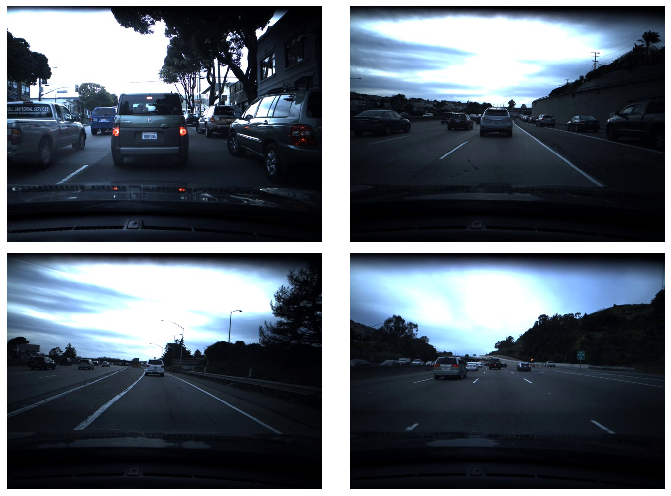

In [38]:
data.show_batch(2, figsize=(10, 7))

### Model

In [39]:
name2id = {v:k for k,v in enumerate(codes)}

In [40]:
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [41]:
metrics = acc_camvid

In [42]:
wd = 1e-2

In [44]:
# learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [49]:
learn = load_learner(path)

### Using get_transformas() here .... just copied the documentation, not sure if this is applied right

In [ ]:
tfms = get_transforms(max_rotate=25)

In [54]:
def get_ex(): return open_image(fnamesVis[20])

def plots_f(rows, cols, width, height, **kwargs):
    [get_ex().apply_tfms(tfms[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
        rows,cols,figsize=(width,height))[1].flatten())]

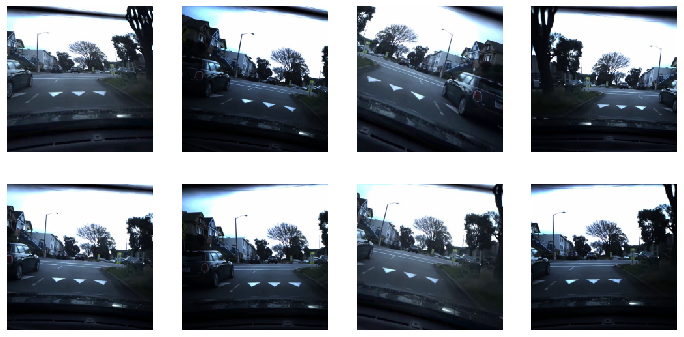

In [55]:
### Should i do this to all images?

plots_f(2, 4, 12, 6, size=224)

In [50]:
learn.predict(data)

AttributeError: apply_tfms